In [1]:
%matplotlib inline
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
plt.style.use('ggplot')

El siguiente data set contiene la cantidad de pasajeros (en miles) que viajan al mes a lo largo del tiempo

<AxesSubplot:xlabel='Date'>

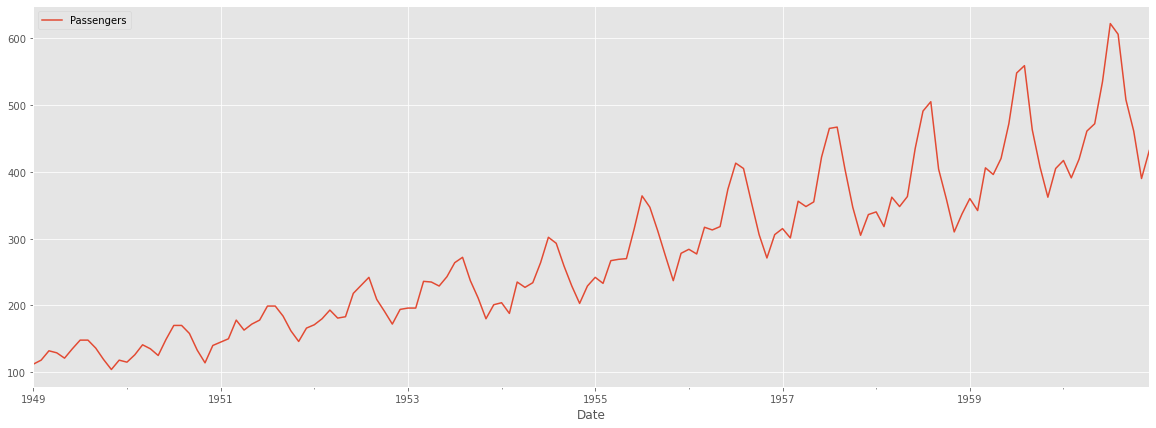

In [2]:
Xt = 'Passengers'
AirlinePassengersDF = pd.read_csv('../data/AirlinePassengers.csv')
AirlinePassengersDF['Date'] = pd.to_datetime(AirlinePassengersDF['Date'],format='%Y/%m')
AirlinePassengersDF = AirlinePassengersDF.set_index('Date')
AirlinePassengersDF[[Xt]].plot(figsize=(20,7))

In [55]:
AirlinePassengersDF.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


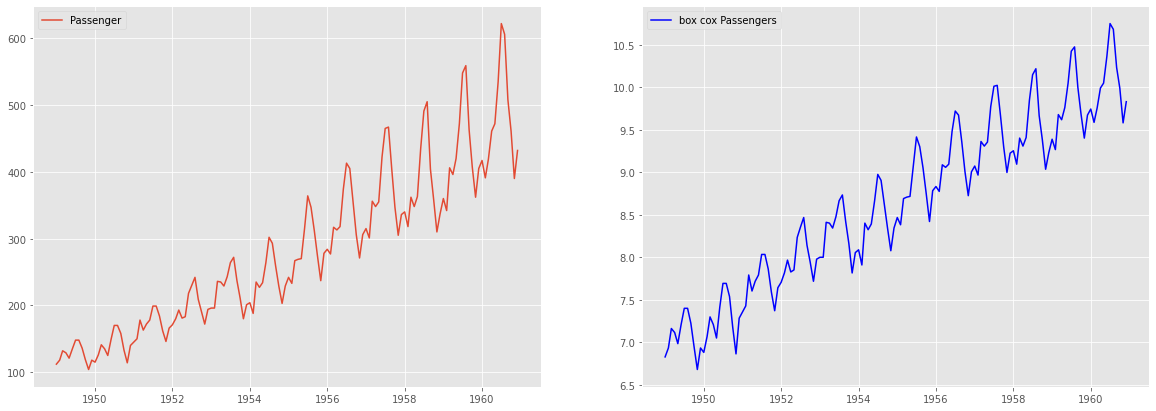

In [56]:
# estandarizacion vía box cox para estabilizar la varianza
box_cox_transform = PowerTransformer(method='box-cox',standardize=False,copy=True).fit(AirlinePassengersDF[['Passengers']])
# la linea anterior regresa un objeto que tra info sobre la transformada de box cox

# la primera entrada es la operacion que se le aplcia a una columna y la segunda el nombre de la columna
bc_transformed_df = pd.DataFrame(box_cox_transform.transform(AirlinePassengersDF[['Passengers']]),
                                 columns=['T(Passengers)']) #creamos una nuava columna con la transformada 
                                 # esto regresa la columna con la varianza estandarizada

# ajustamos el indice como la fecha 
bc_transformed_df['Date'] = AirlinePassengersDF.index
bc_transformed_df.set_index('Date',inplace=True)

# al data set original se le pega la transformacion y se plotea
AirlinePassengersDF['T(Passengers)'] = bc_transformed_df['T(Passengers)'].copy()
#AirlinePassengersDF[['Passengers']].plot(figsize=(10,5))
#AirlinePassengersDF[['T(Passengers)']].plot(figsize=(10,5), color = 'blue');

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.plot(AirlinePassengersDF.index , AirlinePassengersDF[['Passengers']], label = 'Passenger')
ax2.plot(AirlinePassengersDF.index , AirlinePassengersDF[['T(Passengers)']], color = 'blue', label = 'box cox Passengers')
ax1.legend()
ax2.legend()
plt.show();

Aquí podemos observar que la transdormacion de box cox nos hace ver una varianza constante

Tamnbién podemos notar que lo que falta estabiliazr es la media, pues la serie tiene una tendencia y dado que la tendencia se ve lineal (en relacion a comportamientos polinómicos) aplicaremos una diferencia de 1

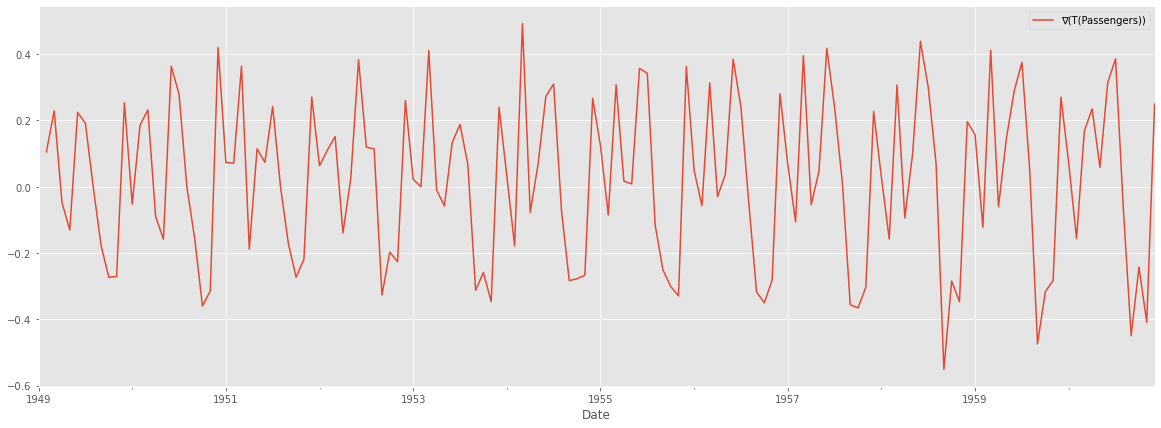

In [57]:
AirlinePassengersDF[['∇(T(Passengers))']] = AirlinePassengersDF[['T(Passengers)']].diff(1) #aplicamos la diferencia
AirlinePassengersDF[['∇(T(Passengers))']].plot(figsize = (20, 7));

A pesar de que ya se ve mas o menos estacionaria la serie, se ve que tiene ciclos, esos ciclos los podemos notar porque se ven ciertos patrones (3 picos cada cierto tiempo) en la serie.
Para ver cada cuando se están viendo estos ciclos, necesitaremos sacar los correlogramas simples y parciales pero de la serie ya trasnformada y diferenciada una vez

correlograma simple
correlograma parcial


C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


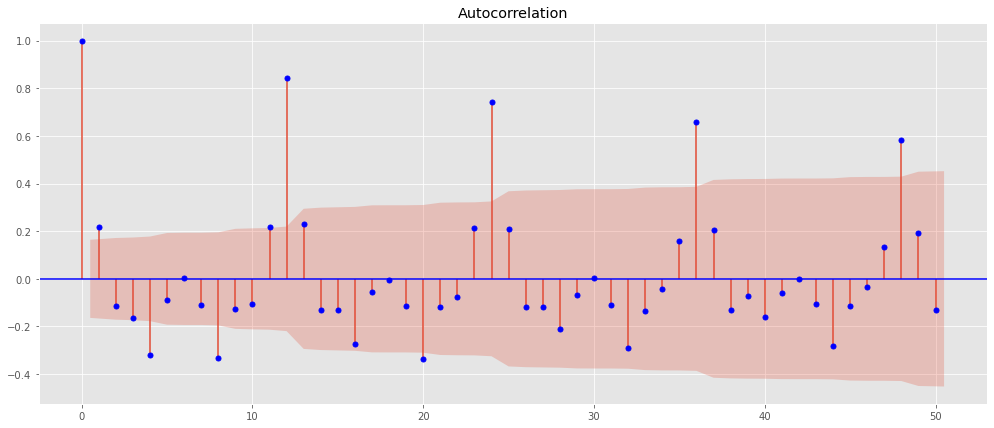

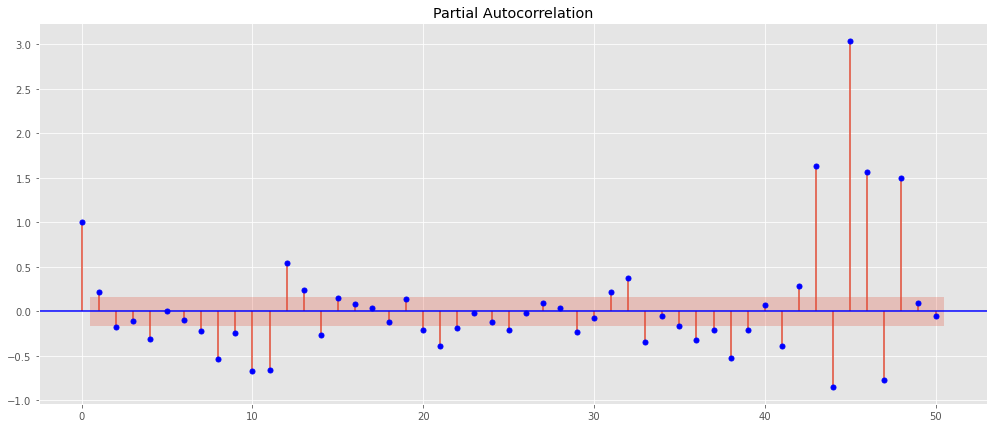

In [58]:
lags = 50

plt.style.use('ggplot')
plt.figsize=(15,10)
# se aplica drop na para poder plotear los correlogramas, ya que con la diferencia perdemos datos
print('correlograma simple')
fig = plot_acf(AirlinePassengersDF['∇(T(Passengers))'].dropna(),lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
print('correlograma parcial')
fig = plot_pacf(AirlinePassengersDF['∇(T(Passengers))'].dropna(),lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show();

Podemos ver que en el correlograma simple se muestran cada 12 *tiempos* una correlacion fuerte, esto nos indica que debemosaplicar una diferencia de 12 posiciones, pues el correlograma simple muestra una fuerte correlacion cada 12 periodos

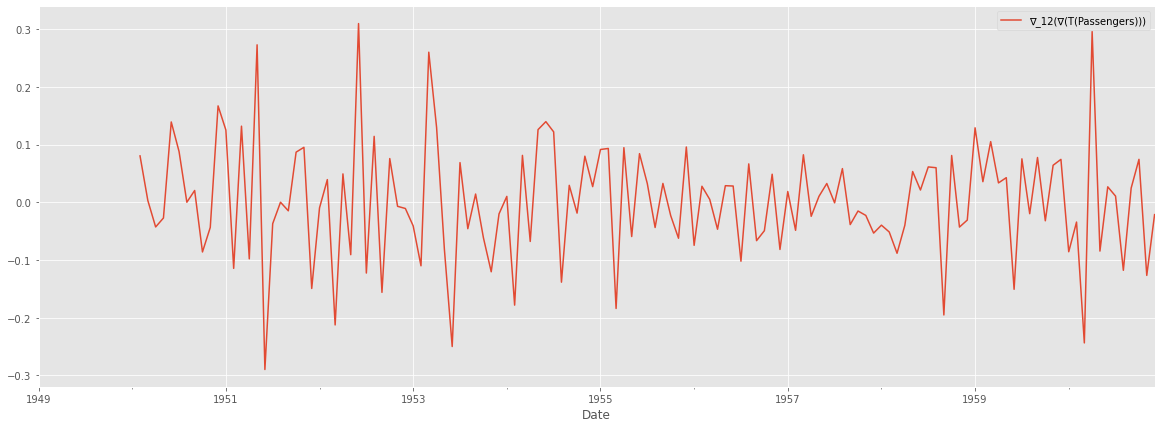

In [59]:
AirlinePassengersDF[['∇_12(∇(T(Passengers)))']] = AirlinePassengersDF[['∇(T(Passengers))']].diff(12)
AirlinePassengersDF[['∇_12(∇(T(Passengers)))']].plot(figsize=(20,7));

In [60]:
# observemos las columnas que trae nuestro df
AirlinePassengersDF.head(14)

,Passengers,T(Passengers),∇(T(Passengers)),∇_12(∇(T(Passengers)))
Date,,,,
1949-01-01,112,6.827490,NaN,NaN
1949-02-01,118,6.932822,0.105332,NaN
1949-03-01,132,7.161892,0.229069,NaN
1949-04-01,129,7.114611,-0.047281,NaN
1949-05-01,121,6.983787,-0.130824,NaN
1949-06-01,135,7.208265,0.224479,NaN
1949-07-01,148,7.399598,0.191333,NaN
1949-08-01,148,7.399598,0.000000,NaN
1949-09-01,136,7.223528,-0.176070,NaN


Es claro que cuando aplicamos la diferencia de 12, no tengamos datos hasta el registro 14, esto se debe a que en estos pasos hemos ido perdiendo informacion

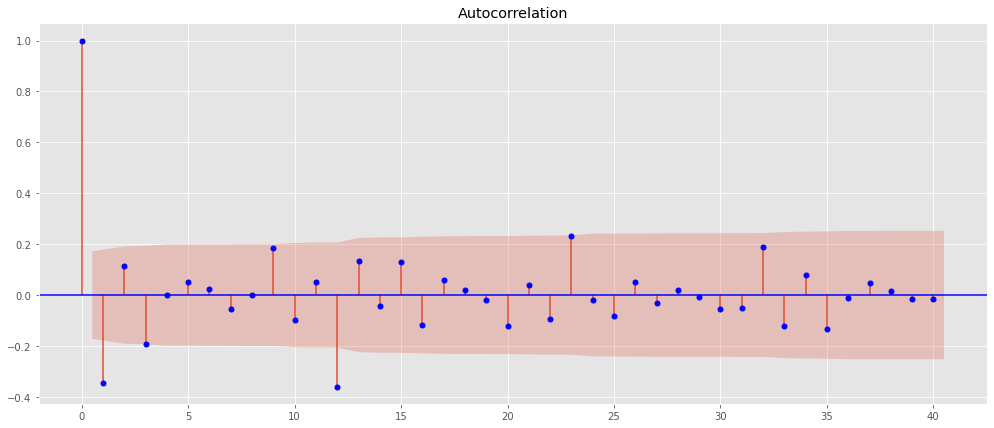

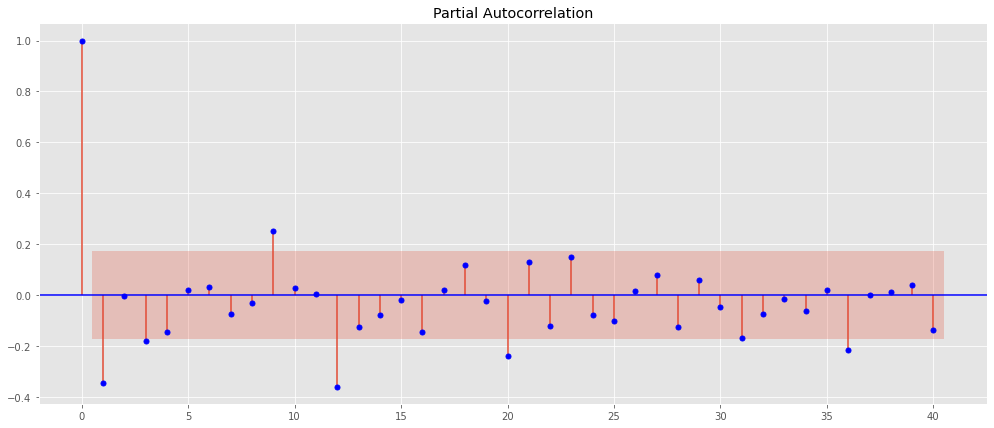

In [61]:
lags = 40
plt.style.use('ggplot')
plt.figsize=(15,10)
fig = plot_acf(AirlinePassengersDF[['∇_12(∇(T(Passengers)))']][14:],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
fig = plot_pacf(AirlinePassengersDF[['∇_12(∇(T(Passengers)))']][14:],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show()

Ahora obtenemos los correlogramas a la serie después de haber aplicado la diferencia de 12, observando las correlaaciones, en la simple podemos ver que aun hay una dependencia de la 12° con la primera, pero tambien podemos ver que el correlograma simple muestra una correlación (al menos de manera autorregresiva) significativa. Ahora observando el autocorrelograma parcial podemos ver que la 12° tambien presenta una fuerte correlación con la primera (ruido de la media movil), (suponiendo una media movil).

Lo que es claro, es que esta serie es *seasonal 12* porque en ambos correlogramas hay una dependencia con la observacion 12, lo que nos infiere usar un SARMA o SARIMA

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#arima "normal"
or_ar = 0
or_ma = 1
d  = 0

#arima con "saltos"
seas_or_ar = 1
seas_or_ma = 0
seas_d     = 0
season = 12

# ajustamos sobre el dato 14 en adelante porque lo anterior es un nulo
# recordemos que un SARIMA trae un ARIMA "normal" y uno (otro ARIMA) 
# con tomando saltos de n (season) periodos  
AirlinePassengersModel = SARIMAX(AirlinePassengersDF['∇_12(∇(T(Passengers)))'][14:],
                                 order=(or_ar, d, or_ma), seasonal_order=(seas_or_ar, seas_d, seas_or_ma, season),).fit(trend='nc')
AirlinePassengersModel.summary()

C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jonat\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              ∇_12(∇(T(Passengers)))   No. Observations:                  130
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                 133.853
Date:                             Fri, 06 May 2022   AIC                           -261.706
Time:                                     22:16:48   BIC                           -253.104
Sample:                                 03-01-1950   HQIC                          -258.211
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4304      0.071     -6.051      0.000      -0.570      -0.291
ar.S.L12      -0.4500      0.074     -6.053      0.000      -0.596      -0.304
sigma2         0.0073      0.001      8.547      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.99   Prob(JB):                         0.64
Heteroskedasticity (H):               0.74   Skew:                             0.17
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Lo que podemos decir despues de observar que los intervalos de confianza no tocan al cero es: tenemos un S(eanal)ARMA, donde la MA es isgnificativa, es decir, la media actual es el promedio movil del anterior y la parte autoregresiva (seasonal) que indica que el valor actual esta muy relacionado con el de 12 posiciones atrás

,∇_12(∇(T(Passengers))),∇(T(Passengers))_12,T(Passengers)_1,∇(T(Passengers)),T(Passengers),predicted_Passengers
Date,,,,,,
1960-01-01,-0.085853,0.157019,9.233167,0.071166,9.304333,347.264116
1960-02-01,-0.034375,-0.122125,9.390186,-0.156500,9.233686,337.073982
1960-03-01,-0.243898,0.412088,9.268061,0.168191,9.436252,366.996155
1960-04-01,0.295713,-0.060562,9.680150,0.235152,9.915301,446.895074
1960-05-01,-0.084687,0.143247,9.619588,0.058561,9.678149,405.666223
1960-06-01,0.026706,0.287885,9.762835,0.314591,10.077426,477.090173
1960-07-01,0.010598,0.375544,10.050720,0.386142,10.436862,550.287523
1960-08-01,-0.118024,0.050621,10.426264,-0.067404,10.358860,533.639754
1960-09-01,0.024514,-0.473990,10.476885,-0.449476,10.027409,467.594780


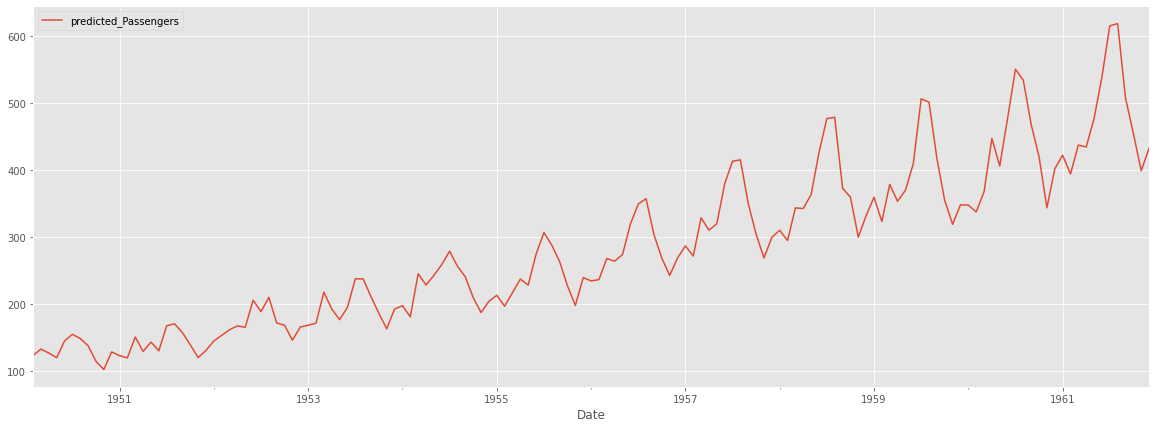

In [34]:
#predicciones de 12 valores (porque tenemos datos mensuales), loq ue devuelve es una
# serie de pandas
prediction_series = AirlinePassengersModel.predict(start='1961-01-01',end='1961-12-01')

# al final de la ultima columan que creamos, agregamos las predicciones
newSeries = AirlinePassengersDF['∇_12(∇(T(Passengers)))'].append(prediction_series)

#recordemos que manoseamos mucho la serie original, entonces hay que hacerle el procesamiento
# inverso para recuperal los pasajeros originales
# entonces en nuedo df, colocamos la serie con todo y predicciones
newAirlinePassengersDF = pd.DataFrame(newSeries,columns=['∇_12(∇(T(Passengers)))'])\
                           .reset_index()\
                           .rename(columns={'index':'Date'})

# creamos un rango de fechas, del que traen las predicciones para poder regresar la serie
# a los datos originales la freq = 'MS' es mensual
new_dates = pd.date_range('1961-01-01','1961-12-01',freq='MS')

# reseteamos el indice para poder hacer un join de las fechas con los datos originales
lagged_dif_12_df = AirlinePassengersDF[['∇(T(Passengers))']].reset_index()[['Date','∇(T(Passengers))']]

# llenamos de na's para poder hacer el cruce, es decir pegar la ultim
newlagged_dif_12_df = pd.DataFrame([[date,np.nan] for date in new_dates],columns=['Date','∇(T(Passengers))'])

# appendeamos la columna del nabla de 12
lagged_dif_12_df = lagged_dif_12_df.append(newlagged_dif_12_df)
# lo colocamos con 12 diferencias para poder regresar la diferencia de 12 (sumar con la posicion 12 anteriro)
lagged_dif_12_df['∇(T(Passengers))_12'] = lagged_dif_12_df['∇(T(Passengers))'].shift(12)
lagged_dif_12_df.drop(columns=['∇(T(Passengers))'],inplace=True) # se borra la nabla original

#talacha similar para 
lagged_dif_1_df = AirlinePassengersDF[['T(Passengers)']].reset_index()[['Date','T(Passengers)']]
#llenamos de nulos para las fechas nuevas 
newlagged_dif_1_df = pd.DataFrame([[date,np.nan] for date in new_dates],columns=['Date','T(Passengers)'])
# y ahora regresamos (apendemos los ultimos 12 datos) la primer diferencia que inducimos de un comportamiento lineal
lagged_dif_1_df = lagged_dif_1_df.append(newlagged_dif_1_df)
# cancelamos la diferencia de uno (adelantamos la serie)
lagged_dif_1_df['T(Passengers)_1'] = lagged_dif_1_df['T(Passengers)'].shift(13)
lagged_dif_1_df.drop(columns=['T(Passengers)'],inplace=True) # y la borramos 

#ahora hacemos un join para poder operar todo
# join de la tabla original con el lagg de 12 valores adelante y luego con el de un valor hacia delante 
# cruzando por fecha 
newAirlinePassengersDF = newAirlinePassengersDF.merge(lagged_dif_12_df,on='Date',how='left')\
                                               .merge(lagged_dif_1_df,on='Date',how='left').fillna(0)

newAirlinePassengersDF.tail(12*3)

# ahora empiezo a recuperar las operaciones, cancelo la nabla de 12 sumando los correspondientes
newAirlinePassengersDF['∇(T(Passengers))'] = newAirlinePassengersDF['∇_12(∇(T(Passengers)))']+newAirlinePassengersDF['∇(T(Passengers))_12']
# ahora recupero sumando la diferencia de uno
newAirlinePassengersDF['T(Passengers)'] = newAirlinePassengersDF['∇(T(Passengers))']+newAirlinePassengersDF['T(Passengers)_1']
# se reindiza 
newAirlinePassengersDF.set_index('Date',inplace=True)

# usamos la inversa de box cox para tener los pasajeros inciales
bc_inv_transformed_df = pd.DataFrame(box_cox_transform.inverse_transform(newAirlinePassengersDF[['T(Passengers)']]),columns=['Passengers'])
#copiamos el date con index
bc_inv_transformed_df['Date'] = newAirlinePassengersDF.index
bc_inv_transformed_df.set_index('Date',inplace=True)
# y lo creado en la tabla anterior lo ponemos en el dataframe de newairlines
newAirlinePassengersDF['predicted_Passengers'] = bc_inv_transformed_df['Passengers'].copy()

#ploteo
newAirlinePassengersDF[['predicted_Passengers']][13:].plot(figsize=(20,7))
display(newAirlinePassengersDF.tail(24))

los datos estaban hasta el año 61, ahora vemos hasta el año 62